Terrain/Scenery Identification

Classes:
buildings, forest, glacier, mountain, sea, street

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

import pandas as pd 
import random

import keras
from keras.models import Model, load_model, Sequential
from keras.layers import  GlobalAveragePooling2D, Dropout, Dense, Flatten, Convolution2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import  Adam
from keras.applications import ResNet50

from sklearn.metrics import classification_report,confusion_matrix

Set Dataset Path

In [2]:
train_path = "terrain_dataset/train"
test_path = "terrain_dataset/test"
pred_path = "terrain_dataset/pred"

Labeling Classes

In [3]:
labels = []
for folder in os.listdir(train_path):
    labels.append(folder)
print(labels)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [4]:
dicc_labels={i:labels[i] for i in range(0,len(labels))}
print(dicc_labels)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


Resize Images and Read Images

In [5]:
n=[]
s=80 #resize image to (80,80)
_images=[]
_labels=[]

for i,folder in enumerate(labels):
    for image in os.listdir(train_path +'/'+ folder):
        img = os.path.join(train_path +'/'+ folder +'/'+ image)
        img = cv2.imread(img)
        img = cv2.resize(img,(s,s))
        _images.append(img)
        _labels.append(i)
n.append(len(_images))

for i,folder in enumerate(labels):
    for image in os.listdir(test_path +'/'+ folder):
        img = os.path.join(test_path +'/'+ folder +'/'+ image)
        img = cv2.imread(img)
        img = cv2.resize(img,(s,s))
        _images.append(img)
        _labels.append(i)
n.append(len(_images))

_images = np.asarray(_images)
_labels = np.asarray(_labels).astype('int64')
print("images-> ",_images.shape)
print("amount of data per label-> ",np.bincount(_labels))

images->  (17034, 80, 80, 3)
amount of data per label->  [2628 2745 2957 3037 2784 2883]


Rescale Images using StandardScaler

In [6]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
_images =_images.reshape((len(_images),-1))
scal.fit(_images)
_images_scal = scal.transform(_images)

Convert Class Vector to Binary Class Matrix using to_categorical

In [7]:
from keras.utils import to_categorical

X_train=_images_scal[0:n[0]]
X_test=_images_scal[n[0]:n[1]]

y_train=_labels[0:n[0]]
y_test=_labels[n[0]:n[1]]


X_train =X_train.reshape(len(X_train),s,s,3)
X_test = X_test.reshape(len(X_test),s,s,3)

print("train images-> ",X_train.shape,"labels train-> ",y_train.shape)
print("train labels by category-> ",np.bincount(y_train))
print("test images-> ",X_test.shape,"labels train-> ",y_test.shape)
print("test labels by category-> ",np.bincount(y_test))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

train images->  (14034, 80, 80, 3) labels train->  (14034,)
train labels by category->  [2191 2271 2404 2512 2274 2382]
test images->  (3000, 80, 80, 3) labels train->  (3000,)
test labels by category->  [437 474 553 525 510 501]


Create ResNet50 Model

In [8]:
base_resnet = ResNet50(weights= 'imagenet', include_top=False, input_shape= (s, s, 3))
resnet = base_resnet.output
resnet = GlobalAveragePooling2D()(resnet)
resnet = Dropout(0.25)(resnet)
predictions = Dense(6, activation= 'softmax')(resnet)
Resnet50 = Model(inputs = base_resnet.input, outputs = predictions)

Create CNN Model

In [9]:
CNN_model = Sequential()
CNN_model.add(Input(shape=(s,s,3)))
CNN_model.add(Convolution2D(s, kernel_size=3, activation="relu", padding="valid"))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Convolution2D(s*2, kernel_size=3, activation="relu", padding="valid"))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Convolution2D(s/2, kernel_size=3, activation="relu", padding="valid"))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Flatten())
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(6, activation="softmax"))

Optimize ResNet50 using Adam with 0.001 learning rate

In [25]:
adam = Adam(learning_rate = 0.001)
Resnet50.compile(optimizer="adam", loss="categorical_crossentropy",
               metrics=["accuracy","Precision"]
)
Resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 86, 86, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 40, 40, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 40, 40, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

Optimize CNN using Adam with 0.0005 learning rate

In [11]:
adam = Adam(learning_rate = 0.0005)
CNN_model.compile(optimizer="adam", loss="categorical_crossentropy",
               metrics=["accuracy","Precision"]
)
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 80)        2240      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 80)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 160)       115360    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 160)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 40)        57640     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 40)         0

ResNet50 Fitting (5 epochs)

Epoch 1/5
110/110 [==============================] - 415s 4s/step - loss: 0.1853 - accuracy: 0.9381 - precision: 0.9451
Epoch 2/5
110/110 [==============================] - 401s 4s/step - loss: 0.1111 - accuracy: 0.9617 - precision: 0.9647
Epoch 3/5
110/110 [==============================] - 397s 4s/step - loss: 0.0844 - accuracy: 0.9706 - precision: 0.9733
Epoch 4/5
110/110 [==============================] - 426s 4s/step - loss: 0.0827 - accuracy: 0.9717 - precision: 0.9738
Epoch 5/5
110/110 [==============================] - 433s 4s/step - loss: 0.0715 - accuracy: 0.9756 - precision: 0.9776


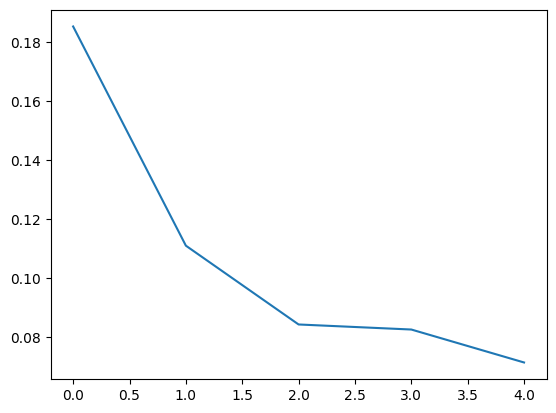

In [26]:
Resnet50_history = Resnet50.fit(
    X_train, y_train, 
    validation_batch_size=(X_test,y_test),
    epochs=5, batch_size=128
)
plt.plot(Resnet50_history.history["loss"])

CNN Fitting (50 epochs)

Epoch 1/50
14/14 [==============================] - 119s 8s/step - loss: 0.4035 - accuracy: 0.8589 - precision: 0.8836
Epoch 2/50
14/14 [==============================] - 94s 7s/step - loss: 0.4016 - accuracy: 0.8586 - precision: 0.8826
Epoch 3/50
14/14 [==============================] - 94s 7s/step - loss: 0.4083 - accuracy: 0.8567 - precision: 0.8810
Epoch 4/50
14/14 [==============================] - 93s 7s/step - loss: 0.3887 - accuracy: 0.8627 - precision: 0.8862
Epoch 5/50
14/14 [==============================] - 93s 7s/step - loss: 0.3872 - accuracy: 0.8668 - precision: 0.8867
Epoch 6/50
14/14 [==============================] - 93s 7s/step - loss: 0.3862 - accuracy: 0.8618 - precision: 0.8866
Epoch 7/50
14/14 [==============================] - 93s 7s/step - loss: 0.3693 - accuracy: 0.8689 - precision: 0.8903
Epoch 8/50
14/14 [==============================] - 93s 7s/step - loss: 0.3671 - accuracy: 0.8680 - precision: 0.8904
Epoch 9/50
14/14 [==============================] - 93s

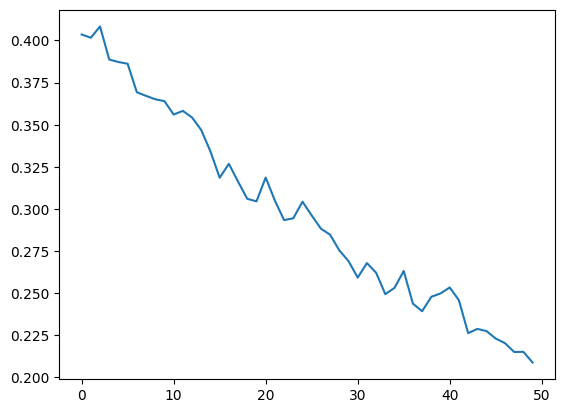

In [22]:
CNN_history = CNN_model.fit(
    X_train, y_train, 
    validation_batch_size=(X_test,y_test),
    epochs=50, batch_size=1024
)
plt.plot(CNN_history.history["loss"])

Classification Report Evaluation

In [27]:
print(dicc_labels)
resnet50_pred = Resnet50.predict(X_test)
print(classification_report(
    np.argmax(y_test,axis=1),
    np.argmax(resnet50_pred, axis=1)
))

cnn_pred = CNN_model.predict(X_test)
print(classification_report(
    np.argmax(y_test,axis=1),
    np.argmax(cnn_pred, axis=1)
))

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
94/94 [==============================] - 22s 210ms/step
              precision    recall  f1-score   support

           0       0.66      0.91      0.76       437
           1       0.99      0.84      0.91       474
           2       0.74      0.65      0.70       553
           3       0.70      0.80      0.74       525
           4       0.83      0.77      0.80       510
           5       0.89      0.76      0.82       501

    accuracy                           0.78      3000
   macro avg       0.80      0.79      0.79      3000
weighted avg       0.80      0.78      0.78      3000

94/94 [==============================] - 7s 60ms/step
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       437
           1       0.95      0.97      0.96       474
           2       0.84      0.79      0.81       553
           3       0.85      0.81      0.83     

Model Accuracy

In [32]:
from sklearn.metrics import accuracy_score
print("ResNet50: ")
print(accuracy_score(np.argmax(y_test,axis=1),
    np.argmax(resnet50_pred, axis=1)))
print("CNN: ")
print(accuracy_score(np.argmax(y_test,axis=1),
    np.argmax(cnn_pred, axis=1)))

ResNet50: 
0.7826666666666666
CNN: 
0.8606666666666667


Implementing Model on pred dataset

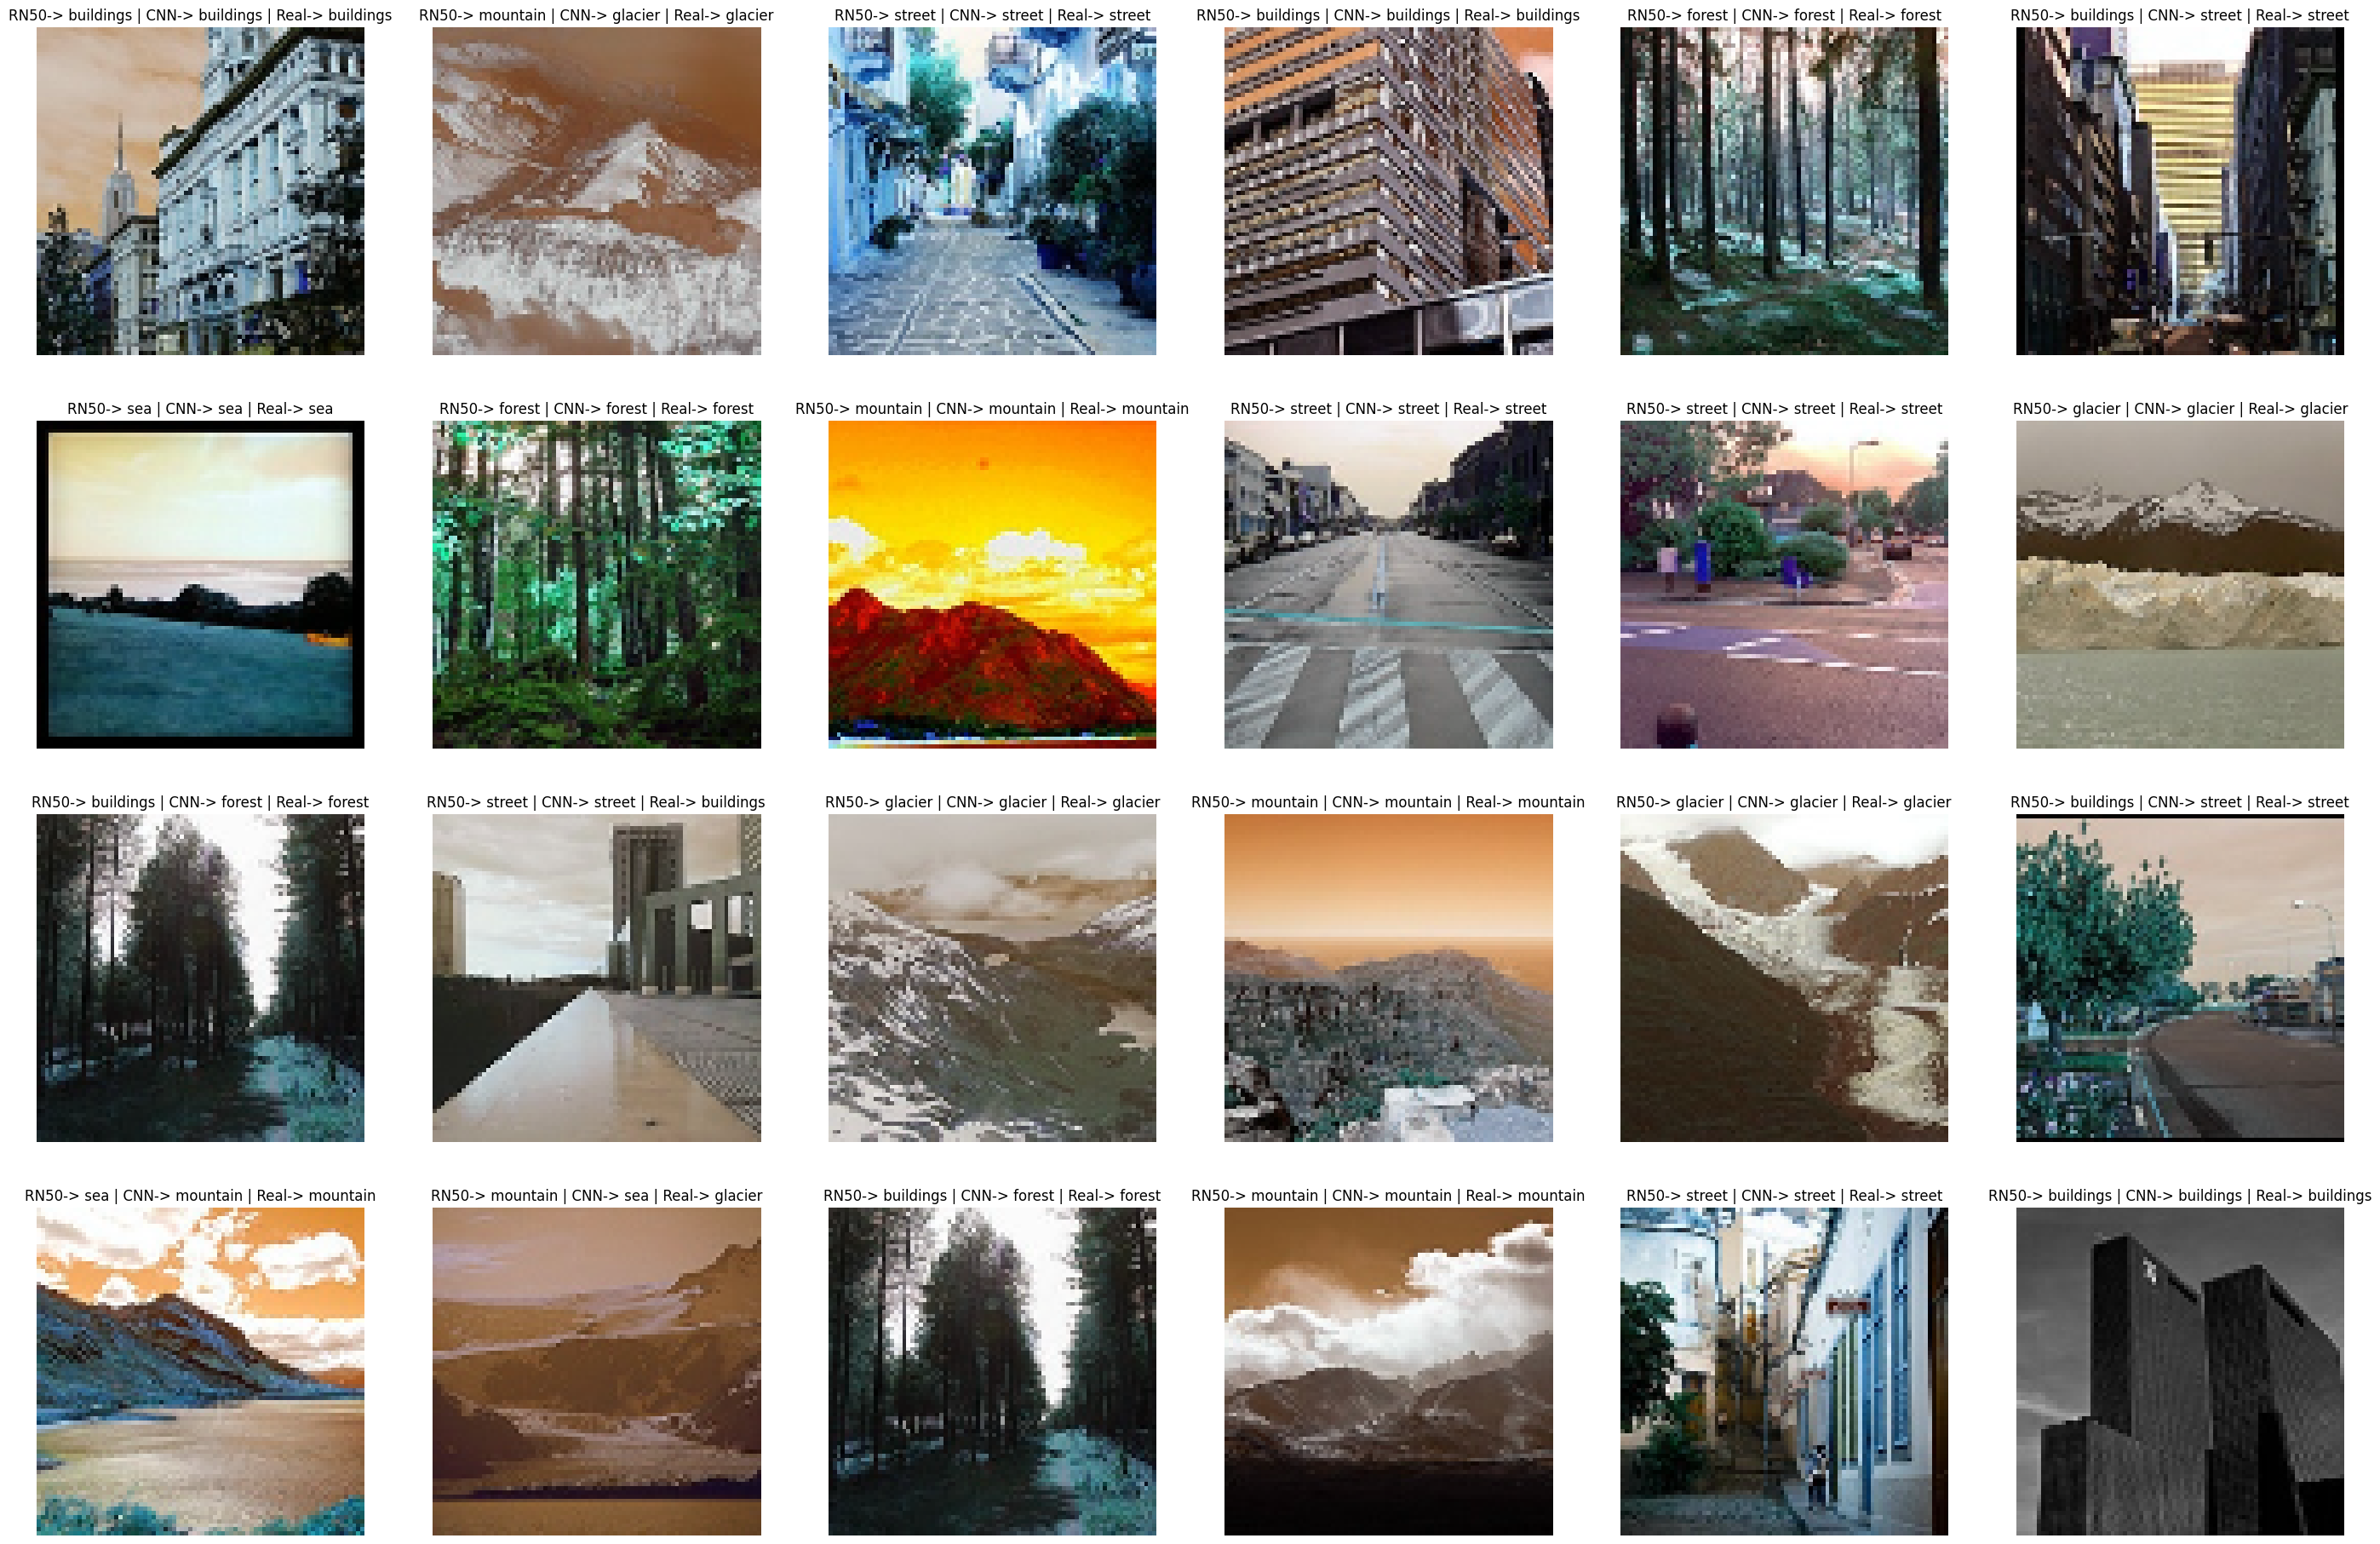

In [28]:
_images =_images.reshape(len(_images),s,s,3)
plt.figure(figsize=(35,35))
for i in range(0,24):
    pos= random.randint(0, 2999)
    plt.subplot(6,6,i+1)
    plt.imshow(_images[n[0]+pos])    
    plt.axis('off')
    plt.title(
        "RN50-> %s | CNN-> %s | Real-> %s"
        %(
            dicc_labels[np.argmax(resnet50_pred[pos])],
            dicc_labels[np.argmax(cnn_pred[pos])],
            dicc_labels[np.argmax(y_test[pos])]
        )
    )
plt.show()

We found a lot of confusion among:
- mountain, sea, and glacier
- street and building
- forest and building

On this research, we found that our CNN model has the better result than our ResNet50 model.